# Item2Vec
Item2Vec: Neural Item Embedding for Collaborative Filtering
***

## References
- Paper: https://arxiv.org/vc/arxiv/papers/1603/1603.04259v2.pdf
- Dataset: https://grouplens.org/datasets/movielens/
- Source Code:
https://github.com/bwange/Item2vec_Tutorial_with_Recommender_System_Application/blob/master/Making_Your_Own_Recommender_System_with_Item2Vec.ipynb

***

##  Preparing the Data
- MovieLens 데이터셋을 사용하여 데이터를 읽습니다.


In [1]:
import pandas as pd
import numpy as np

# 데이터 읽기
df_movies = pd.read_csv('../dataset/ml-20m/movies.csv') # 영화 데이터
df_ratings = pd.read_csv('../dataset/ml-20m/ratings.csv') # user의 rating 데이터

# 인코딩
movieId_to_name = pd.Series(df_movies.title.values, index = df_movies.movieId.values)
name_to_movieId = pd.Series(df_movies.movieId.values, index = df_movies.title).to_dict()

# Randomly display 5 records in the dataframe
for df in list((df_movies, df_ratings)):
    rand_idx = np.random.choice(len(df), 5, replace=False)
    display(df.iloc[rand_idx,:])
    print("Randomly displaying 5 of the total "+str(len(df))+" data points")

,movieId,title,genres
4903,4999,Dodsworth (1936),Drama|Romance
22418,107630,High School (2010),Comedy
10535,39703,Little Fish (2005),Crime|Drama|Romance|Thriller
21653,104865,Ping Pong (2012),Documentary
8137,8820,Spinout (1966),Comedy|Musical


Randomly displaying 5 of the total 27278 data points


,userId,movieId,rating,timestamp
11538517,79641,537,5.0,837388707
18436672,127615,2324,3.0,949789468
83744,593,195,3.0,862658718
17262126,119384,1200,3.5,1079582071
10203944,70604,919,4.0,1107415170


Randomly displaying 5 of the total 20000263 data points


## Rating Histogram
- User가 rating한 영화의 개수를 히스토그램으로 시각화합니다.

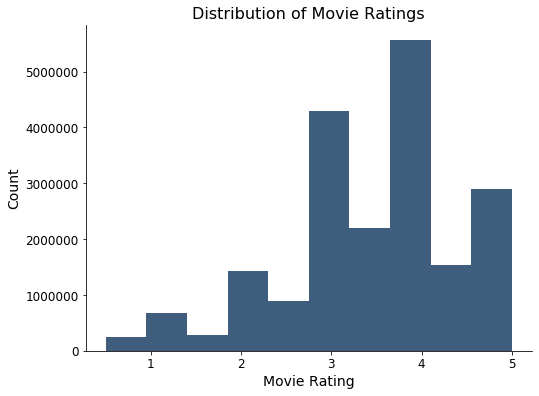

In [2]:
import matplotlib.pyplot as plt
import chart_studio.plotly as py
%matplotlib inline

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set_title("Distribution of Movie Ratings", fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
  
plt.xlabel("Movie Rating", fontsize=14)  
plt.ylabel("Count", fontsize=14)  
  
plt.hist(df_ratings['rating'], color="#3F5D7D")  

plt.show()

##  train set, test set 만들기
- ratings 데이터의 학습데이터와 테스트데이터를 분리합니다.

In [ ]:
from sklearn.model_selection import train_test_split

df_ratings_train, df_ratings_test= train_test_split(df_ratings,
                                                    stratify=df_ratings['userId'],
                                                    random_state = 15688,
                                                    test_size=0.30)


print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

user의 평가 데이터를 기준으로 데이터를 구분하여 영화정보를 추출합니다.

In [4]:
def rating_splitter(df):
    
    df['liked'] = np.where(df['rating']>=4, 1, 0) # df['rating']이 4이상이면 1 아니면 0
    df['movieId'] = df['movieId'].astype('str')
    gp_user_like = df.groupby(['liked', 'userId']) # liked와 user_id로 그룹화
    return ([gp_user_like.get_group(gp)['movieId'].tolist() for gp in gp_user_like.groups]) 

즉, user 정보는 무시하고 movieId만 반환합니다.

In [20]:
pd.options.mode.chained_assignment = None
splitted_movies = rating_splitter(df_ratings_train)

***
## 모델 생성 및 학습

In [11]:

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
assert gensim.models.word2vec.FAST_VERSION > -1

In [29]:
len(splitted_movies)

276252

In [21]:
new_splitted_movies = splitted_movies[:1000]

Shuufle train data
- 영화의 순서는 의미있는 정보가 아니므로 학습데이터를 셔플링합니다.

In [23]:
import random

for movie_list in new_splitted_movies:
    random.shuffle(movie_list)

모델을 생성합니다.
- Skip-gram을 사용한 Word2Vec 모델을 생성합니다.
- 각 파라미터를 다르게 설정하여 2가지 모델을 만들었습니다.

In [25]:

from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences = new_splitted_movies, # We will supply the pre-processed list of moive lists to this parameter
                 iter = 5, # epoch
                 min_count = 10, # a movie has to appear more than 10 times to be keeped
                 size = 200, # size of the hidden layer
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 5, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
model.save('item2vec_20200908')
del model

Time passed: 0:00:15.709966


In [ ]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model_w2v_sg = Word2Vec(sentences = splitted_movies,
                        iter = 10, # epoch
                        min_count = 5, # a movie has to appear more than 5 times to be keeped
                        size = 300, # size of the hidden layer
                        workers = 4, # specify the number of threads to be used for training
                        sg = 1,
                        hs = 0,
                        negative = 5,
                        window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
model_w2v_sg.save('item2vec_word2vecSg_20200908')
del model_w2v_sg

생성한 모델을 load합니다.

In [30]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_20200908')
word_vectors = model.wv
# del model # uncomment this line will delete the model

***

## Let's Make Some Recommendations!

In [107]:
import requests
import re
from bs4 import BeautifulSoup

def refine_search(search_term):
    """
    Refine the movie name to be recognized by the recommender
    Args:
        search_term (string): Search Term

    Returns:
        refined_term (string): a name that can be search in the dataset
    """
    target_url = "http://www.imdb.com/find?ref_=nv_sr_fn&q="+"+".join(search_term.split())+"&s=tt"
    
    # 크롤링
    html = requests.get(target_url).content
    parsed_html = BeautifulSoup(html, 'html.parser')
    for tag in parsed_html.find_all('td', class_="result_text"):
        print(tag)
        title = tag.find('a').get_text()
        year = re.findall('</a>(.*)</td>', str(tag))

        return title + ' ' + year[0].strip()
        print(search_result)
        refined_name = ""
        if search_result:
            if search_result[0][0].split()[0]=="The":
                str_frac = " ".join(title.split()[1:])+", "+title.split()[0]
                refined_name = title + ' ' + year[0].strip()
            else:
                refined_name = title + ' ' + year[0].strip()
        return refined_name

def produce_list_of_movieId(list_of_movieName, useRefineSearch=False):
    """
    Turn a list of movie name into a list of movie ids. The movie names has to be exactly the same as they are in the dataset.
    Ambiguous movie names can be supplied if useRefineSearch is set to True
    
    Args:
        list_of_movieName (List): A list of movie names.
        useRefineSearch (boolean): Ambiguous movie names can be supplied if useRefineSearch is set to True

    Returns:
        list_of_movie_id (List of strings): A list of movie ids.
    """
    list_of_movie_id = []
    for movieName in list_of_movieName:
        if useRefineSearch:
            movieName = refine_search(movieName)
            print(movieName)
            print("Refined Name: "+movieName)
        if movieName in name_to_movieId.keys():
            list_of_movie_id.append(str(name_to_movieId[movieName]))
    return list_of_movie_id

def recommender(positive_list=None, negative_list=None, useRefineSearch=False, topn=20):
    recommend_movie_ls = []
    if positive_list:
        positive_list = produce_list_of_movieId(positive_list, useRefineSearch)
    if negative_list:
        negative_list = produce_list_of_movieId(negative_list, useRefineSearch)
    for movieId, prob in model.wv.most_similar_cosmul(positive=positive_list, negative=negative_list, topn=topn):
        recommend_movie_ls.append(movieId)
    return recommend_movie_ls

In [109]:
ls = recommender(positive_list=["UP"], useRefineSearch=True, topn=5)
print('Recommendation Result based on "Up (2009)":')
display(df_movies[df_movies['movieId'].isin(ls)])

<td class="result_text"> <a href="/title/tt1049413/">Up</a> (2009) </td>
Up (2009)
Refined Name: Up (2009)
Recommendation Result based on "Up (2009)":


,movieId,title,genres
4794,4890,Shallow Hal (2001),Comedy|Fantasy|Romance
5574,5673,Punch-Drunk Love (2002),Comedy|Drama|Romance
7318,7444,13 Going on 30 (2004),Comedy|Fantasy|Romance
11352,48385,Borat: Cultural Learnings of America for Make ...,Comedy
12089,54997,3:10 to Yuma (2007),Action|Crime|Drama|Western


In [111]:
ls = recommender(positive_list=["The Matrix", "Django Unchained"], useRefineSearch=True, topn=7)
print('Recommendation Result based on "The Matrix (1999)" + ""Django Unchained (2012)":')
display(df_movies[df_movies['movieId'].isin(ls)])

<td class="result_text"> <a href="/title/tt0133093/">The Matrix</a> (1999) </td>
The Matrix (1999)
Refined Name: The Matrix (1999)
<td class="result_text"> <a href="/title/tt1853728/">Django Unchained</a> (2012) </td>
Django Unchained (2012)
Refined Name: Django Unchained (2012)


KeyError: "word '99114' not in vocabulary"